In [1]:
# import required packages
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch

from PIL import Image

import json
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.nn.modules.loss import _Loss
from torch.autograd import Variable
from tqdm import tqdm

from sklearn.linear_model import LinearRegression

In [2]:
json_gt = [json.loads(line) for line in open('G:/lanelanet/archive/test_label_new.json')]

In [3]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir(path)
    zip_name = f"{path}/{download_file_name}.zip"
    command = f"zip -r {zip_name} {path}"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

# Utils

In [4]:
def split_path(path):
    """split path tree into list"""
    folders = []
    while True:
        path, folder = os.path.split(path)
        if folder != "":
            folders.insert(0, folder)
        else:
            if path != "":
                folders.insert(0, path)
            break
    return folders

def getLane_tusimple(prob_map, y_px_gap, pts, thresh, resize_shape=None):
    """
    Arguments:
    ----------
    prob_map: prob map for single lane, np array size (h, w)
    resize_shape:  reshape size target, (H, W)

    Return:
    ----------
    coords: x coords bottom up every y_px_gap px, 0 for non-exist, in resized shape
    """
    if resize_shape is None:
        resize_shape = prob_map.shape
    h, w = prob_map.shape
    H, W = resize_shape

    coords = np.zeros(pts)
    for i in range(pts):
        y = int((H - 10 - i * y_px_gap) * h / H)
        if y < 0:
            break
        line = prob_map[y, :]
        id = np.argmax(line)
        if line[id] > thresh:
            coords[i] = int(id / w * W)
    if (coords > 0).sum() < 2:
        coords = np.zeros(pts)
    return coords

def prob2lines_tusimple(seg_pred, exist, resize_shape=None, smooth=True, y_px_gap=10, pts=None, thresh=0.3):
    """
    Arguments:
    ----------
    seg_pred:      np.array size (5, h, w)
    resize_shape:  reshape size target, (H, W)
    exist:       list of existence, e.g. [0, 1, 1, 0]
    smooth:      whether to smooth the probability or not
    y_px_gap:    y pixel gap for sampling
    pts:     how many points for one lane
    thresh:  probability threshold

    Return:
    ----------
    coordinates: [x, y] list of lanes, e.g.: [ [[9, 569], [50, 549]] ,[[630, 569], [647, 549]] ]
    """
    if resize_shape is None:
        resize_shape = seg_pred.shape[1:]  # seg_pred (5, h, w)
    _, h, w = seg_pred.shape
    H, W = resize_shape
    coordinates = []

    if pts is None:
        pts = round(H / 2 / y_px_gap)

    seg_pred = np.ascontiguousarray(np.transpose(seg_pred, (1, 2, 0)))
    for i in range(6):
        prob_map = seg_pred[..., i + 1]
        if smooth:
            prob_map = cv2.blur(prob_map, (9, 9), borderType=cv2.BORDER_REPLICATE)
        if exist[i] > 0:
            coords = getLane_tusimple(prob_map, y_px_gap, pts, thresh, resize_shape)
            coordinates.append(
                [[coords[j], H - 10 - j * y_px_gap] if coords[j] > 0 else [-1, H - 10 - j * y_px_gap] for j in
                 range(pts)])

    return coordinates

class LaneEval(object):
    lr = LinearRegression()
    pixel_thresh = 20
    pt_thresh = 0.85

    @staticmethod
    def get_angle(xs, y_samples):
        xs, ys = xs[xs >= 0], y_samples[xs >= 0]
        if len(xs) > 1:
            LaneEval.lr.fit(ys[:, None], xs)
            k = LaneEval.lr.coef_[0]
            theta = np.arctan(k)
        else:
            theta = 0
        return theta

    @staticmethod
    def line_accuracy(pred, gt, thresh):
        pred = np.array([p if p >= 0 else -100 for p in pred])
        gt = np.array([g if g >= 0 else -100 for g in gt])
        return np.sum(np.where(np.abs(pred - gt) < thresh, 1., 0.)) / len(gt)

    @staticmethod
    def bench(pred, gt, y_samples, running_time):
        if any(len(p) != len(y_samples) for p in pred):
            raise Exception('Format of lanes error.')
        if running_time > 200 or len(gt) + 2 < len(pred):
            return 0., 0., 1.
        angles = [LaneEval.get_angle(np.array(x_gts), np.array(y_samples)) for x_gts in gt]
        threshs = [LaneEval.pixel_thresh / np.cos(angle) for angle in angles]
        line_accs = []
        fp, fn = 0., 0.
        matched = 0.
        for x_gts, thresh in zip(gt, threshs):
            accs = [LaneEval.line_accuracy(np.array(x_preds), np.array(x_gts), thresh) for x_preds in pred]
            max_acc = np.max(accs) if len(accs) > 0 else 0.
            if max_acc < LaneEval.pt_thresh:
                fn += 1
            else:
                matched += 1
            line_accs.append(max_acc)
        fp = len(pred) - matched
        if len(gt) > 4 and fn > 0:
            fn -= 1
        s = sum(line_accs)
        if len(gt) > 4:
            s -= min(line_accs)
        return s / max(min(4.0, len(gt)), 1.), fp / len(pred) if len(pred) > 0 else 0., fn / max(min(len(gt), 4.) , 1.)

    @staticmethod
    def bench_one_submit(pred_file, gt_file):
        try:
            json_pred = [json.loads(line) for line in open(pred_file).readlines()]
        except BaseException as e:
            raise Exception('Fail to load json file of the prediction.')
        json_gt = [json.loads(line) for line in open(gt_file).readlines()]
        if len(json_gt) != len(json_pred):
            raise Exception('We do not get the predictions of all the test tasks')
        gts = {l['raw_file']: l for l in json_gt}
        accuracy, fp, fn = 0., 0., 0.
        for pred in json_pred:
            if 'raw_file' not in pred or 'lanes' not in pred or 'run_time' not in pred:
                raise Exception('raw_file or lanes or run_time not in some predictions.')
            raw_file = pred['raw_file']
            pred_lanes = pred['lanes']
            run_time = pred['run_time']
            if raw_file not in gts:
                raise Exception('Some raw_file from your predictions do not exist in the test tasks.')
            gt = gts[raw_file]
            gt_lanes = gt['lanes']
            y_samples = gt['h_samples']
            try:
                a, p, n = LaneEval.bench(pred_lanes, gt_lanes, y_samples, run_time)
            except BaseException as e:
                raise Exception('Format of lanes error.')
            accuracy += a
            fp += p
            fn += n
        num = len(gts)
        # the first return parameter is the default ranking parameter
        return json.dumps([
            {'name': 'Accuracy', 'value': accuracy / num, 'order': 'desc'},
            {'name': 'FP', 'value': fp / num, 'order': 'asc'},
            {'name': 'FN', 'value': fn / num, 'order': 'asc'}
        ])
    
    
def bench_one(pred_file, gt_file):
    try:
        json_pred = [json.loads(line) for line in open(pred_file).readlines()]
    except BaseException as e:
        raise Exception('Fail to load json file of the prediction.')
    json_gt = [json.loads(line) for line in open(gt_file).readlines()]
    if len(json_gt) != len(json_pred):
        raise Exception('We do not get the predictions of all the test tasks')
    gts = {l['raw_file']: l for l in json_gt}
    accuracy, fp, fn = 0., 0., 0.
    accuracy_list = []
    for pred in json_pred:
        if 'raw_file' not in pred or 'lanes' not in pred or 'run_time' not in pred:
            raise Exception('raw_file or lanes or run_time not in some predictions.')
        raw_file = pred['raw_file']
        pred_lanes = pred['lanes']
        run_time = pred['run_time']
        if raw_file not in gts:
            raise Exception('Some raw_file from your predictions do not exist in the test tasks.')
        gt = gts[raw_file]
        gt_lanes = gt['lanes']
        y_samples = gt['h_samples']
        try:
            a, p, n = LaneEval.bench(pred_lanes, gt_lanes, y_samples, run_time)
            accuracy_list.append((a, raw_file))
        except BaseException as e:
                raise Exception('Format of lanes error.')
    return accuracy_list

In [6]:
def to_one_hot(tensor, nClasses):
    n, h, w = tensor.size()
    one_hot = torch.zeros(n, nClasses, h, w).to(tensor.device).scatter_(1, tensor.view(n, 1, h, w), 1)
    return one_hot


class mIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=6):
        super(mIoULoss, self).__init__()
        self.classes = n_classes

    def forward(self, inputs, target_oneHot):
        """
        IoU Loss for individual examples
        inputs - N x {Classes or higher} x H x W
        target_oneHot - N x {Classes or higher} x H x W
        BG can be ignored
        """

        N = inputs.size()[0]
        C = inputs.size()[1]

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs, dim=1)

        # Numerator Product
        inter = inputs * target_oneHot
        # Sum over all pixels N x C x H x W => N x C
        inter = inter.view(N, C, -1).sum(2)

        # Denominator
        union = inputs + target_oneHot - (inputs * target_oneHot)
        # Sum over all pixels N x C x H x W => N x C
        union = union.view(N, C, -1).sum(2)

        loss = inter / union

        ## Return average loss over classes and batch
        return -(loss[:, -self.classes].mean() - 1.)

# LaneDataset class

In [7]:
PATH = 'G:/lanelanet/archive/TUSimple'

class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path= PATH, train=True, size=(800, 288)):
        self._dataset_path = dataset_path
        self._mode = "train" if train else "test"
        self._image_size = size # w, h
        self._data = []

        if self._mode == "train":
            file_path = "train_val_gt.txt"
        elif self._mode == "test":
            file_path = "test_gt.txt"
        self._process_list(os.path.join(self._dataset_path, "train_set/seg_label/list", file_path))
            
    def __getitem__(self, idx):
        img_path = self._dataset_path + ("/train_set" if self._mode == "train" else "/test_set") + self._data[idx][0]
        image = cv2.imread(img_path)
        h, w, c = image.shape
        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ins_segmentation_path = self._dataset_path + "/train_set" + self._data[idx][1]
        ins_segmentation_image = cv2.imread(ins_segmentation_path)
        ins_segmentation_image = ins_segmentation_image[:, :, 0]
        ins_segmentation_image = cv2.resize(ins_segmentation_image, self._image_size, interpolation=cv2.INTER_LINEAR)
        
        segmentation_image = ins_segmentation_image.copy()
        segmentation_image[segmentation_image > 0] = 1
        
        image = torch.from_numpy(image).float().permute((2, 0, 1))
        segmentation_image = torch.from_numpy(segmentation_image.copy()).to(torch.int64)
        ins_segmentation_image =  torch.from_numpy(ins_segmentation_image.copy())
        
        exists = [int(i) for i in self._data[idx][2]]
        exists = torch.as_tensor(exists)
        
        output = {
            'img_path' : img_path,
            'img' : image,
            'segLabel' : segmentation_image,
            'IsegLabel' : ins_segmentation_image,
            'exist' : exists
        }
        
        return output
    
    def _process_list(self, file_path):
        with open(file_path) as f:
            for line in f:
                words = line.split()
                image = words[0]
                segmentation = words[1]
                exists = words[2:]
                self._data.append((image, segmentation, exists))        
                
    def __len__(self):
        return len(self._data)  

# Models

In [8]:
# Enet pytorch code retrieved from https://github.com/davidtvs/PyTorch-ENet/blob/master/models/enet.py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter


class InitialBlock(nn.Module):
    """The initial block is composed of two branches:
    1. a main branch which performs a regular convolution with stride 2;
    2. an extension branch which performs max-pooling.
    Doing both operations in parallel and concatenating their results
    allows for efficient downsampling and expansion. The main branch
    outputs 13 feature maps while the extension branch outputs 3, for a
    total of 16 feature maps after concatenation.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number output channels.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - As stated above the number of output channels for this
        # branch is the total minus 3, since the remaining channels come from
        # the extension branch
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 3,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        # Extension branch
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Initialize batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate branches
        out = torch.cat((main, ext), 1)

        # Apply batch normalization
        out = self.batch_norm(out)

        return self.out_activation(out)


class RegularBottleneck(nn.Module):
    """Regular bottlenecks are the main building block of ENet.
    Main branch:
    1. Shortcut connection.
    Extension branch:
    1. 1x1 convolution which decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. regular, dilated or asymmetric convolution;
    3. 1x1 convolution which increases the number of channels back to
    ``channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - channels (int): the number of input and output channels.
    - internal_ratio (int, optional): a scale factor applied to
    ``channels`` used to compute the number of
    channels after the projection. eg. given ``channels`` equal to 128 and
    internal_ratio equal to 2 the number of channels after the projection
    is 64. Default: 4.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer described above in item 2 of the extension
    branch. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - dilation (int, optional): spacing between kernel elements for the
    convolution described in item 2 of the extension branch. Default: 1.
    asymmetric (bool, optional): flags if the convolution described in
    item 2 of the extension branch is asymmetric or not. Default: False.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class DownsamplingBottleneck(nn.Module):
    """Downsampling bottlenecks further downsample the feature map size.
    Main branch:
    1. max pooling with stride 2; indices are saved to be used for
    unpooling later.
    Extension branch:
    1. 2x2 convolution with stride 2 that decreases the number of channels
    by ``internal_ratio``, also called a projection;
    2. regular convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``channels``
    used to compute the number of channels after the projection. eg. given
    ``channels`` equal to 128 and internal_ratio equal to 2 the number of
    channels after the projection is 64. Default: 4.
    - return_indices (bool, optional):  if ``True``, will return the max
    indices along with the outputs. Useful when unpooling later.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices


class UpsamplingBottleneck(nn.Module):
    """The upsampling bottlenecks upsample the feature map resolution using max
    pooling indices stored from the corresponding downsampling bottleneck.
    Main branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. max unpool layer using the max pool indices from the corresponding
    downsampling max pool layer.
    Extension branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. transposed convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``in_channels``
     used to compute the number of channels after the projection. eg. given
     ``in_channels`` equal to 128 and ``internal_ratio`` equal to 2 the number
     of channels after the projection is 64. Default: 4.
    - dropout_prob (float, optional): probability of an element to be zeroed.
    Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if ``True``.
    Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class SpatialSoftmax(nn.Module):
    def __init__(self, temperature=1, device='cpu'):
        super(SpatialSoftmax, self).__init__()

        if temperature:
            self.temperature = Parameter(torch.ones(1) * temperature).to(device)
        else:
            self.temperature = 1.

    def forward(self, feature):
        feature = feature.view(feature.shape[0], -1, feature.shape[1] * feature.shape[2])
        softmax_attention = F.softmax(feature / self.temperature, dim=-1)

        return softmax_attention


class ENet_SAD(nn.Module):
    """Generate the ENet model.
    Keyword arguments:
    - num_classes (int): the number of classes to segment.
    - encoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the encoder blocks/layers; otherwise, PReLU
    is used. Default: False.
    - decoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the decoder blocks/layers; otherwise, PReLU
    is used. Default: True.
    - sad (bool, optional): When ``True``, SAD is added to model
    . If False, SAD is removed.
    """

    def __init__(self, input_size, sad=False, encoder_relu=False, decoder_relu=True, weight_share=True, dataset='TUSimple'):
        super().__init__()

        # Init parameter
        input_w, input_h = input_size
        self.fc_input_feature = 7 * int(input_w / 16) * int(input_h / 16)
        self.num_classes = 7 if dataset != 'BDD100K' else 1
        self.scale_background = 0.4

        # Loss scale factor for ENet w/o SAD
        self.scale_seg = 1.0
        self.scale_exist = 0.1

        # Loss scale factor for ENet w SAD
        self.scale_sad_seg = 1.0
        self.scale_sad_iou = 0.1
        self.scale_sad_exist = 0.1
        self.scale_sad_distill = 0.1

        # Loss function
        self.dataset = dataset
        if dataset != 'BDD100K':
            self.ce_loss = nn.CrossEntropyLoss(weight=torch.tensor([self.scale_background, 1, 1, 1, 1, 1, 1]))
            self.bce_loss = nn.BCELoss()
            self.iou_loss = mIoULoss(n_classes=6)
        else:
            self.ce_loss = nn.BCEWithLogitsLoss()
            self.bce_loss = nn.BCELoss()
            self.iou_loss = mIoULoss(n_classes=1)

        # Encoder generator
        def get_encoder_block(n=2):
            seq = nn.Sequential()
            seq.add_module('regular%d_1' % n, RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu))
            seq.add_module('dilated%d_2' % n, RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu))
            seq.add_module('asymmetric%d_3' % n, RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu))
            seq.add_module('dilated%d_4' % n, RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu))
            seq.add_module('regular%d_5' % n, RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu))
            seq.add_module('dilated%d_6' % n, RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu))
            seq.add_module('asymmetric%d_7' % n, RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu))
            seq.add_module('dilated%d_8' % n, RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu))
            return seq

        # Stage 0 - Initial block
        self.initial_block = InitialBlock(3, 16, relu=encoder_relu)
        self.sad = sad

        # Stage 1 - Encoder (E1)
        self.downsample1 = DownsamplingBottleneck(16, 64, return_indices=True, dropout_prob=0.01, relu=encoder_relu)
        self.encoder1 = nn.Sequential()
        self.encoder1.add_module('regular1_1', RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu))
        self.encoder1.add_module('regular1_2', RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu))
        self.encoder1.add_module('regular1_3', RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu))
        self.encoder1.add_module('regular1_4', RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu))

        # Shared Encoder (E2~E4)
        # Stage 2 - Encoder (E2)
        self.downsample2 = DownsamplingBottleneck(64, 128, return_indices=True, dropout_prob=0.1, relu=encoder_relu)
        self.encoder2 = get_encoder_block(n=2)

        # Stage 3 - Encoder (E3)
        self.encoder3 = self.encoder2 if weight_share else get_encoder_block(3)

        # Stage 4 - Encoder (E4)
        self.encoder4 = self.encoder2 if weight_share else get_encoder_block(4)

        # Stage 5 - Decoder (D1)
        self.upsample4_0 = UpsamplingBottleneck(256, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)

        # Stage 6 - Decoder (D2)
        self.upsample5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.transposed_conv = nn.ConvTranspose2d(16, self.num_classes, kernel_size=3, stride=2, padding=1, bias=False)

        # AT_GEN
        if self.sad:
            self.at_gen_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
            self.at_gen_l2_loss = nn.MSELoss(reduction='mean')

        # Lane exist (P1)
        self.exist = nn.Sequential(nn.Conv2d(128, self.num_classes, 1),
                                   nn.Softmax(dim=1),
                                   nn.AvgPool2d(2, 2),)
        self.fc = nn.Sequential(nn.Linear(self.fc_input_feature, 128),
                                nn.ReLU(),
                                nn.Linear(128, 6),
                                nn.Sigmoid(),)

    def at_gen(self, x1, x2):
        """
        x1 - previous encoder step feature map
        x2 - current encoder step feature map
        """

        # G^2_sum
        sps = SpatialSoftmax(device=x1.device)

        if x1.size() != x2.size():
            x1 = x1.pow(2).sum(dim=1)
            x1 = sps(x1)
            x2 = x2.pow(2).sum(dim=1, keepdim=True)
            x2 = torch.squeeze(self.at_gen_upsample(x2), dim=1)
            x2 = sps(x2)
        else:
            x1 = x1.pow(2).sum(dim=1)
            x1 = sps(x1)
            x2 = x2.pow(2).sum(dim=1)
            x2 = sps(x2)

        loss = self.at_gen_l2_loss(x1, x2)
        return loss

    def forward(self, img, seg_gt=None, exist_gt=None, sad_loss=False):
        # Stage 0 - Initial block
        input_size = img.size()
        x_0 = self.initial_block(img)

        # AT-GEN after each E2, E3, E4
        # Stage 1 - Encoder (E1)
        stage1_input_size = x_0.size()
        x, max_indices1 = self.downsample1(x_0)
        x_1 = self.encoder1(x)

        # Stage 2 - Encoder (E2)
        stage2_input_size = x_1.size()
        x, max_indices2 = self.downsample2(x_1)
        x_2 = self.encoder2(x)
        if self.sad:
            loss_2 = self.at_gen(x_1, x_2)

        # Stage 3 - Encoder (E3)
        x_3 = self.encoder3(x_2)
        if self.sad:
            loss_3 = self.at_gen(x_2, x_3)

        # Stage 4 - Encoder (E4)
        x_4 = self.encoder4(x_3)
        if self.sad:
            loss_4 = self.at_gen(x_3, x_4)

        # Concatenate E3, E4
        x_34 = torch.cat((x_3, x_4), dim=1)

        # Stage 4 - Decoder (D1)
        x = self.upsample4_0(x_34, max_indices2, output_size=stage2_input_size)
        x = self.regular4_1(x)
        x = self.regular4_2(x)

        # Stage 5 - Decoder (D2)
        x = self.upsample5_0(x, max_indices1, output_size=stage1_input_size)
        x = self.regular5_1(x)
        seg_pred = self.transposed_conv(x, output_size=input_size)

        # lane exist
        y = self.exist(x_4)
        y = y.view(-1, self.fc_input_feature)
        exist_pred = self.fc(y)

        # loss calculation
        if seg_gt is not None and exist_gt is not None:
            # L = L_seg + a * L_iou + b * L_exist + c * L_distill
            if self.sad:
                if self.dataset != 'BDD100K':
                    loss_seg = self.ce_loss(seg_pred, seg_gt.long())
#                     seg_gt_onehot = to_one_hot(seg_gt, 7)
                    seg_gt_onehot = F.one_hot(seg_gt.long(), num_classes = 7)
                    seg_gt_onehot = seg_gt_onehot.permute(0, 3, 1, 2)
                else:
                    loss_seg = self.ce_loss(seg_pred.squeeze(dim=1), seg_gt.float())
                    seg_gt_onehot = seg_gt.unsqueeze(dim=1)

#                 loss_iou = self.iou_loss(seg_pred, seg_gt_onehot)
                loss_iou = self.iou_loss(seg_pred, seg_gt_onehot.long())
                loss_exist = self.bce_loss(exist_pred, exist_gt.float())
                loss = loss_seg * self.scale_sad_seg + loss_iou * self.scale_sad_iou + loss_exist * self.scale_sad_exist

                # Add SAD loss after 40K episodes
                if sad_loss:
                    loss_distill = loss_2 + loss_3 + loss_4
                    loss += loss_distill * self.scale_sad_distill

            else:
                loss_seg = self.ce_loss(seg_pred, seg_gt.long())
                loss_exist = self.bce_loss(exist_pred, exist_gt.float())
                loss = loss_seg * self.scale_seg + loss_exist * self.scale_exist

        else:
            loss_seg = torch.tensor(0, dtype=img.dtype, device=img.device)
            loss_exist = torch.tensor(0, dtype=img.dtype, device=img.device)
            loss = torch.tensor(0, dtype=img.dtype, device=img.device)

        return seg_pred, exist_pred, loss_seg, loss_exist, loss

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


class SCNN(nn.Module):
    def __init__(
            self,
            input_size,
            ms_ks=9,
            pretrained=True
    ):
        """
        Argument
            ms_ks: kernel size in message passing conv
        """
        super(SCNN, self).__init__()
        self.pretrained = pretrained
        self.net_init(input_size, ms_ks)
        if not pretrained:
            self.weight_init()

        self.scale_background = 0.4
        self.scale_seg = 1.0
        self.scale_exist = 0.1

        self.ce_loss = nn.CrossEntropyLoss(weight=torch.tensor([self.scale_background, 1, 1, 1, 1, 1, 1]))
        self.bce_loss = nn.BCELoss()

    def forward(self, img, seg_gt=None, exist_gt=None):
        x = self.backbone(img)
        x = self.layer1(x)
        x = self.message_passing_forward(x)
        x = self.layer2(x)

        seg_pred = F.interpolate(x, scale_factor=8, mode='bilinear', align_corners=True)

        x = self.layer3(x)
        x = x.view(-1, self.fc_input_feature)
        exist_pred = self.fc(x)

        if seg_gt is not None and exist_gt is not None:
            loss_seg = self.ce_loss(seg_pred, seg_gt.long())
            loss_exist = self.bce_loss(exist_pred, exist_gt.float())
            loss = loss_seg * self.scale_seg + loss_exist * self.scale_exist
        else:
            loss_seg = torch.tensor(0, dtype=img.dtype, device=img.device)
            loss_exist = torch.tensor(0, dtype=img.dtype, device=img.device)
            loss = torch.tensor(0, dtype=img.dtype, device=img.device)

        return seg_pred, exist_pred, loss_seg, loss_exist, loss

    def message_passing_forward(self, x):
        Vertical = [True, True, False, False]
        Reverse = [False, True, False, True]
        for ms_conv, v, r in zip(self.message_passing, Vertical, Reverse):
            x = self.message_passing_once(x, ms_conv, v, r)
        return x

    def message_passing_once(self, x, conv, vertical=True, reverse=False):
        """
        Argument:
        ----------
        x: input tensor
        vertical: vertical message passing or horizontal
        reverse: False for up-down or left-right, True for down-up or right-left
        """
        nB, C, H, W = x.shape
        if vertical:
            slices = [x[:, :, i:(i + 1), :] for i in range(H)]
            dim = 2
        else:
            slices = [x[:, :, :, i:(i + 1)] for i in range(W)]
            dim = 3
        if reverse:
            slices = slices[::-1]

        out = [slices[0]]
        for i in range(1, len(slices)):
            out.append(slices[i] + F.relu(conv(out[i - 1])))
        if reverse:
            out = out[::-1]
        return torch.cat(out, dim=dim)

    def net_init(self, input_size, ms_ks):
        input_w, input_h = input_size
        self.fc_input_feature = 7 * int(input_w/16) * int(input_h/16)
        self.backbone = models.vgg16_bn(pretrained=self.pretrained).features

        # ----------------- process backbone -----------------
        for i in [34, 37, 40]:
            conv = self.backbone._modules[str(i)]
            dilated_conv = nn.Conv2d(
                conv.in_channels, conv.out_channels, conv.kernel_size, stride=conv.stride,
                padding=tuple(p * 2 for p in conv.padding), dilation=2, bias=(conv.bias is not None)
            )
            dilated_conv.load_state_dict(conv.state_dict())
            self.backbone._modules[str(i)] = dilated_conv
        self.backbone._modules.pop('33')
        self.backbone._modules.pop('43')

        # ----------------- SCNN part -----------------
        self.layer1 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=4, dilation=4, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 128, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()  # (nB, 128, 36, 100)
        )

        # ----------------- add message passing -----------------
        self.message_passing = nn.ModuleList()
        self.message_passing.add_module('up_down', nn.Conv2d(128, 128, (1, ms_ks), padding=(0, ms_ks // 2), bias=False))
        self.message_passing.add_module('down_up', nn.Conv2d(128, 128, (1, ms_ks), padding=(0, ms_ks // 2), bias=False))
        self.message_passing.add_module('left_right',
                                        nn.Conv2d(128, 128, (ms_ks, 1), padding=(ms_ks // 2, 0), bias=False))
        self.message_passing.add_module('right_left',
                                        nn.Conv2d(128, 128, (ms_ks, 1), padding=(ms_ks // 2, 0), bias=False))
        # (nB, 128, 36, 100)

        # ----------------- SCNN part -----------------
        self.layer2 = nn.Sequential(
            nn.Dropout2d(0.1),
            nn.Conv2d(128, 7, 1)  # get (nB, 5, 36, 100)
        )

        self.layer3 = nn.Sequential(
            nn.Softmax(dim=1),  # (nB, 5, 36, 100)
            nn.AvgPool2d(2, 2),  # (nB, 5, 18, 50)
        )
        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_feature, 128),
            nn.ReLU(),
            nn.Linear(128, 6),
            nn.Sigmoid()
        )

    def weight_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.reset_parameters()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data[:] = 1.
                m.bias.data.zero_()

# Dataloaders

In [10]:
dataset = LaneDataset(size=(800, 288))

train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=False)

In [11]:
print(train_dataloader)
print(val_dataloader)

# Check

In [12]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

# tensor = torch.ones((8, 3, 288, 800)).to(device)
# seg_gt = torch.zeros((8, 288, 800)).long().to(device)
# exist_gt = torch.ones((8, 6)).to(device)

# enet_sad = ENet_SAD((800, 288), sad=True, dataset='TUSImple')
# enet_sad.to(device)
# enet_sad.train(mode=True)
# print(enet_sad(tensor, seg_gt, exist_gt, sad_loss=True)[0].shape)
# print(enet_sad(tensor, seg_gt, exist_gt, sad_loss=True)[1].shape)

In [13]:
# enet = ENet_SAD((800, 288), sad=False, dataset='TUSImple')
# enet.to(device)
# enet.train(mode=True)
# print(enet(tensor, seg_gt, exist_gt, sad_loss=True)[0].shape)
# print(enet(tensor, seg_gt, exist_gt, sad_loss=True)[1].shape)

In [14]:
# scnn = SCNN((800, 288), pretrained=True)
# scnn.to(device)
# scnn.train(mode=True)
# result = scnn(tensor, seg_gt, exist_gt)
# print(result[0].shape)
# print(result[1].shape)

# Training

In [12]:
from torch.optim.lr_scheduler import _LRScheduler


class PolyLR(_LRScheduler):
    def __init__(self, optimizer, pow, max_iter, min_lrs=1e-20, last_epoch=-1, warmup=0):
        """
        :param warmup: how many steps for linearly warmup lr
        """
        self.pow = pow
        self.max_iter = max_iter
        if not isinstance(min_lrs, list) and not isinstance(min_lrs, tuple):
            self.min_lrs = [min_lrs] * len(optimizer.param_groups)

        assert isinstance(warmup, int), "The type of warmup is incorrect, got {}".format(type(warmup))
        self.warmup = max(warmup, 0)

        super(PolyLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup:
            return [base_lr / self.warmup * (self.last_epoch+1) for base_lr in self.base_lrs]

        if self.last_epoch < self.max_iter:
            coeff = (1 - (self.last_epoch-self.warmup) / (self.max_iter-self.warmup)) ** self.pow
        else:
            coeff = 0
        return [(base_lr - min_lr) * coeff + min_lr
                for base_lr, min_lr in zip(self.base_lrs, self.min_lrs)]

In [13]:
def val(net, epoch, model_name, device, optimizer, lr_scheduler, best_val_loss):

    print("Val Epoch: {}".format(epoch))

    net.eval()
    val_loss = 0
    val_loss_seg = 0
    val_loss_exist = 0
    progressbar = tqdm(range(len(val_dataloader)))

    with torch.no_grad():
        for batch_idx, sample in enumerate(val_dataloader):
            img = sample['img'].to(device)
            segLabel = sample['IsegLabel'].to(device)
            exist = sample['exist'].to(device)

            seg_pred, exist_pred, loss_seg, loss_exist, loss = net(img, segLabel, exist)

            val_loss += loss.item()
            val_loss_seg += loss_seg.item()
            val_loss_exist += loss_exist.item()

            progressbar.set_description("batch loss: {:.3f}".format(loss.item()))
            progressbar.update(1)

    progressbar.close()
    iter_idx = (epoch + 1) * len(train_dataloader)  # keep align with training process iter_idx

    print("------------------------\n")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        
#         if os.path.exists(prev_save_name):
#             os.remove(prev_save_name)
        
        save_dict = {
            "epoch": epoch,
            "net": net.state_dict(),
            "optim": optimizer.state_dict(),
            "lr_scheduler": lr_scheduler.state_dict(),
            "best_val_loss": best_val_loss
        }
        
        torch.save(save_dict, model_name + '.pth')
        print("model is saved: {}.pth".format(model_name))
        
    return best_val_loss

#     print("------------------------\n")

In [15]:

import time
import numpy as np
from joblib import Parallel, delayed
import os
import subprocess
import psutil
import threading

def measure_performance(device, model_name, net, optimizer, lr_scheduler, epoch, progressbar):
    # Measure latency for training one epoch
    start_time = time.time()

    # Function to process data in parallel
    def process_data_in_parallel(batch_idx, data_chunk, device, model_name, net, optimizer, lr_scheduler, epoch, progressbar):
            batch_start_time = time.time()
            img = data_chunk['img'].to(device)
            segLabel = data_chunk['IsegLabel'].to(device)
            exist = data_chunk['exist'].to(device)

            optimizer.zero_grad()

            if model_name == "scnn":
                seg_pred, exist_pred, loss_seg, loss_exist, loss = net(img, segLabel, exist)
            elif model_name == "enet":
                seg_pred, exist_pred, loss_seg, loss_exist, loss = net(img, segLabel, exist, False)
            elif model_name == "enet_sad":
                if epoch < 20:
                    seg_pred, exist_pred, loss_seg, loss_exist, loss = net(img, segLabel, exist, False)
                else:
#                     print("sad activated")
                    seg_pred, exist_pred, loss_seg, loss_exist, loss = net(img, segLabel, exist, True)

            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            iter_idx = epoch * len(train_dataloader) + batch_idx
            train_loss = loss.item()
            train_loss_seg = loss_seg.item()
            train_loss_exist = loss_exist.item()
            progressbar.set_description("batch loss: {:.3f}".format(loss.item()))
            progressbar.update(1)

            lr = optimizer.param_groups[0]['lr']

            # Print CPU utilization
            cpu_usage = psutil.cpu_percent(interval=1, percpu=True)
            print(f"CPU Core Utilization: {cpu_usage}")

            batch_time = time.time() - batch_start_time
            print(f"Batch Time: {batch_time}")

    # # Measure single-core time
    # start_time = time.time()
    # for chunk in data:
    #     model.train(chunk)
    # single_core_time = time.time() - start_time

    # Measure multi-core time
    multi_core_start_time = time.time()
    Parallel(n_jobs=-1)(delayed(process_data_in_parallel)(batch_idx, chunk, device, model_name, net, optimizer, lr_scheduler, epoch, progressbar) for batch_idx, chunk in enumerate(train_dataloader))
    multi_core_time = time.time() - multi_core_start_time

    # speedup = single_core_time / multi_core_time
    print(f"Multicore time: {multi_core_time}")


    # Monitor CPU utilization during training
    # start_time = time.time()
    # model.train(data)
    # end_time = time.time()

    # Power consumption measurement
    if os.name == 'posix':  # For Linux
        os.system('powerstat -d 1 1')  # Adjust the command and duration as needed
    elif os.name == 'nt':  # For Windows
        subprocess.run(["IntelPowerGadget.exe", "-start"], check=True)
        # Run your ML code here
        subprocess.run(["IntelPowerGadget.exe", "-stop"], check=True)
    else:
        print("Power consumption measurement is not supported on this OS.")



    # # Example function to run in a thread
    # def train_model_in_thread(data_chunk):
    #     model.train(data_chunk)

    # # Create threads for parallel processing
    # threads = []
    # for chunk in data:
    #     thread = threading.Thread(target=train_model_in_thread, args=(chunk,))
    #     threads.append(thread)
    #     thread.start()

    # # Join threads
    # for thread in threads:
    #     thread.join()

    # # Measure CPU utilization again
    # cpu_usage_after = psutil.cpu_percent(interval=1, percpu=True)
    # print(f"CPU Core Utilization after multithreading: {cpu_usage_after}")
    end_time = time.time()

    # Calculate latency
    latency = end_time - start_time
    print(f"Latency: {latency} seconds")

    # Assuming `data` is already defined or loaded previously
    throughput = len(train_dataloader) / latency
    print(f"Throughput: {throughput} samples/second")

# Initialize your model and dataset
#model = ('scnn')
#dataset = np.load('TUSImple')

# Call the performance measurement function
#measure_performance(model, data)


In [16]:
def main(model_name):
    n_epochs = 1
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    if model_name == 'enet_sad':
        net = ENet_SAD((800, 288), sad=True, dataset='TUSImple')
    elif model_name == 'enet':
        net = ENet_SAD((800, 288), sad=False, dataset='TUSImple')
    elif model_name == 'scnn':
        net = SCNN((800, 288), pretrained=True)
        
    net.to(device)
    net.train(mode=True)
        
    optimizer = optim.SGD(net.parameters(), lr= 1e-2, momentum= 0.9,weight_decay= 2e-5,nesterov= True)
    lr_scheduler = PolyLR(optimizer, 0.9, warmup= 50, max_iter= 6000)
    
    best_val_loss = 1e6
        
    for epoch in range(0, n_epochs):
        print("Train Epoch: {}".format(epoch))
        net.train()
        train_loss = 0
        train_loss_seg = 0
        train_loss_exist = 0
        progressbar = tqdm(range(len(train_dataloader)))
        measure_performance(device,model_name,net,optimizer,lr_scheduler,epoch,progressbar)
#         for batch_idx, sample in enumerate(train_dataloader):
#             img = sample['img'].to(device)
#             segLabel = sample['IsegLabel'].to(device)
#             exist = sample['exist'].to(device)

#             optimizer.zero_grad()

#             if model_name == "scnn":
#                 seg_pred, exist_pred, loss_seg, loss_exist, loss = net(img, segLabel, exist)
#             elif model_name == "enet":
#                 seg_pred, exist_pred, loss_seg, loss_exist, loss = net(img, segLabel, exist, False)
#             elif model_name == "enet_sad":
#                 if epoch < 20:
#                     seg_pred, exist_pred, loss_seg, loss_exist, loss = net(img, segLabel, exist, False)
#                 else:
# #                     print("sad activated")
#                     seg_pred, exist_pred, loss_seg, loss_exist, loss = net(img, segLabel, exist, True)

#             loss.backward()
#             optimizer.step()
#             lr_scheduler.step()

#             iter_idx = epoch * len(train_dataloader) + batch_idx
#             train_loss = loss.item()
#             train_loss_seg = loss_seg.item()
#             train_loss_exist = loss_exist.item()
#             progressbar.set_description("batch loss: {:.3f}".format(loss.item()))
#             progressbar.update(1)

#             lr = optimizer.param_groups[0]['lr']
#             measure_performance(model, dataset)            
        progressbar.close()
        
        if epoch % 1 == 0:
            best_val_loss = val(net, epoch, model_name, device, optimizer, lr_scheduler, best_val_loss)

    download_file('models', model_name + '.pth')

In [19]:
main('enet')

Train Epoch: 0


PicklingError: Could not pickle the task to send it to the workers.

# Test

In [19]:
test_dataset = LaneDataset(train = False, size=(800, 288))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [25]:
def test(model_name, save_name):
    directory = os.path.join("G:/lanelanet", model_name + '_test')
    os.mkdir(directory)
    out_path = os.path.join(directory, "coord_output")
    evaluation_path = os.path.join(directory, "evaluate")
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    if not os.path.exists(evaluation_path):
        os.mkdir(evaluation_path)
    dump_to_json = []

    n_epochs = int(np.ceil(60000 / len(train_dataloader)))
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    if (model_name == 'enet_sad') or (model_name == 'enet'):
        net = ENet_SAD((800, 288), sad=False, dataset='TUSImple')
#     elif model_name == 'enet':
#         net = ENet_SAD((800, 288), sad=False, dataset='TUSImple')
    elif model_name == 'scnn':
        net = SCNN((800, 288), pretrained=True)
        
    net.to(device)

    save_name = os.path.join('G:/lanelanet', save_name)
    save_dict = torch.load(save_name, map_location='cpu')
    print("\nloading", save_name, "...... From Epoch: ", save_dict['epoch'])
    net.load_state_dict(save_dict['net'])
    net = net.to(device)
    net.eval()
    
    progressbar = tqdm(range(len(test_loader)))
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            img = sample['img'].to(device)
            
            
            img_name = sample['img_path']
#             img_name = os.path.basename(img_path)

            seg_pred, exist_pred = net(img)[:2]
            seg_pred = F.softmax(seg_pred, dim=1)
            seg_pred = seg_pred.detach().cpu().numpy()
            exist_pred = exist_pred.detach().cpu().numpy()

            for b in range(len(seg_pred)):
                seg = seg_pred[b]
                exist = [1 if exist_pred[b, i] > 0.5 else 0 for i in range(6)]
                lane_coords = prob2lines_tusimple(seg, exist, resize_shape=(720, 1280), y_px_gap=10, pts=56)
                for i in range(len(lane_coords)):
                    lane_coords[i] = sorted(lane_coords[i], key=lambda pair: pair[1])

                path_tree = split_path(img_name[b])
                save_dir, save_name = path_tree[-3:-1], path_tree[-1]
                save_dir = os.path.join(out_path, *save_dir)
                save_name = save_name[:-3] + "lines.txt"
                save_name = os.path.join(save_dir, save_name)
                if not os.path.exists(save_dir):
                    os.makedirs(save_dir, exist_ok=True)

                with open(save_name, "w") as f:
                    for l in lane_coords:
                        for (x, y) in l:
                            print("{} {}".format(x, y), end=" ", file=f)
                        print(file=f)

                json_dict = {}
                json_dict['lanes'] = []
                json_dict['h_sample'] = []
                json_dict['raw_file'] = (os.path.join(*path_tree[-4:])).replace('\\', '/')
                json_dict['run_time'] = 0
                for l in lane_coords:
                    if len(l) == 0:
                        continue
                    json_dict['lanes'].append([])
                    for (x, y) in l:
                        json_dict['lanes'][-1].append(int(x))
                for (x, y) in lane_coords[0]:
                    json_dict['h_sample'].append(y)
                dump_to_json.append(json.dumps(json_dict))

            progressbar.update(1)
    progressbar.close()

    with open(os.path.join(out_path, "predict_test.json"), "w") as f:
        for line in dump_to_json:
            print(line, end="\n", file=f)
            
    eval_result = LaneEval.bench_one_submit(os.path.join(directory, "coord_output", "predict_test.json"), os.path.join("G:/lanelanet/archive/TUSimple","test_label.json"))
    print(eval_result)
    with open(os.path.join(directory, "evaluate", "evaluation_result.txt"), "w") as f:
        print(eval_result, file=f)

In [28]:
 test('enet_sad', 'G:/lanelanet/models/enet_sad.pth')


loading G:/lanelanet/models/enet_sad.pth ...... From Epoch:  0
















































































































































































100%|██████████| 174/174 [08:41<00:00,  3.00s/it]


[{"name": "Accuracy", "value": 0.43022962240251905, "order": "desc"}, {"name": "FP", "value": 0.9763659237958303, "order": "asc"}, {"name": "FN", "value": 0.9761262880421762, "order": "asc"}]


In [ ]:
# test('enet', '/kaggle/input/enet-res/enet.pth')

In [ ]:
# test('scnn', '/kaggle/input/scnn-res/scnn.pth')

# Visualisation

In [32]:
acc_enet = bench_one("G:/lanelanet/enet_sad_test/coord_output/predict-test.json", 
                     os.path.join("G:/lanelanet/archive/TUSimple","test_label.json"))
acc_enet.sort(key=lambda x: x[0])

Exception: Fail to load json file of the prediction.

In [34]:
acc_enet_sad = bench_one("G:/lanelanet/enet_sad_test/coord_output/predict_test.json", 
                     os.path.join("G:/lanelanet/archive/TUSimple","test_label.json"))
acc_enet_sad.sort(key=lambda x: x[0])

In [ ]:
acc_scnn = bench_one("/kaggle/input/predict-test/scnn_test.json", 
                     os.path.join("/kaggle/input/tusimple/TUSimple","test_label.json"))
acc_scnn.sort(key=lambda x: x[0])

In [45]:
def predict(model, image):
    image = torch.from_numpy(image).float().permute((2, 0, 1)).unsqueeze(dim=0)

    model.eval()
    seg_pred = model(image)[0]
    seg_pred = F.softmax(seg_pred, dim=1)
    seg_pred = torch.argmax(seg_pred, dim=1)
    seg_pred = seg_pred.detach().cpu().numpy()

    return np.transpose(seg_pred, (1, 2, 0))


def predict_image(model, score_img):
    score, img_path = score_img
    image = cv2.imread("G:/lanelanet/archive/TUSimple/test_set/" + img_path)
    image = cv2.resize(image, (800, 288), interpolation=cv2.INTER_LINEAR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    seg_pred = predict(net, image)

    # Ground truth    
    gt = [(x['lanes'], x['h_samples']) for x in json_gt if x['raw_file'].split('/')[3] == img_path.split('/')[2]]
    gt_lanes = gt[0][0]
    y_samples = gt[0][1]

    gt_lanes_vis = [[(x, y) for (x, y) in zip(lane, y_samples) if x >= 0] for lane in gt_lanes]
    img_vis = image.copy()
    img_vis = cv2.resize(img_vis, (1280, 720), interpolation=cv2.INTER_LINEAR)

    for lane in gt_lanes_vis:
        for pt in lane:
            cv2.circle(img_vis, pt, radius=5, color=(255, 0, 0), thickness= 2)
    
    img_vis = cv2.resize(img_vis, (800, 288), interpolation=cv2.INTER_LINEAR)
    plt.imshow(img_vis)

    # Preds
    plt.imshow(seg_pred * 1, cmap='jet', vmin=1, vmax=7, alpha=0.3)
    plt.axis('off')
    
    plt.show()


    print(str(round(score, 3)))
#     plt.subplot(2,2,2)
#     plt.imshow(image)
#     plt.imshow(seg_pred * 1, cmap='jet', vmin=1, vmax=7, alpha=0.3)

## Enet

In [ ]:
save_dict = torch.load("/kaggle/input/enet-res/enet.pth", map_location='cpu')

net = ENet_SAD((800, 288), sad=False, dataset='TUSImple')
net.load_state_dict(save_dict['net'])

In [ ]:
predict_image(net, acc_enet[-1])

In [ ]:
predict_image(net, acc_enet[-2])

In [ ]:
predict_image(net, acc_enet[-3])

In [ ]:
predict_image(net, acc_enet[0])

In [ ]:
predict_image(net, acc_enet[1])

In [ ]:
predict_image(net, acc_enet[2])

## Enet-SAD

In [46]:
save_dict = torch.load("G:/lanelanet/models/enet_sad.pth", map_location='cpu')

net = ENet_SAD((800, 288), sad=False, dataset='TUSImple')
net.load_state_dict(save_dict['net'])

<All keys matched successfully>

In [47]:
print(acc_enet_sad[-1])

(0.8348214285714286, 'clips/0601/1495485005644829619/20.jpg')


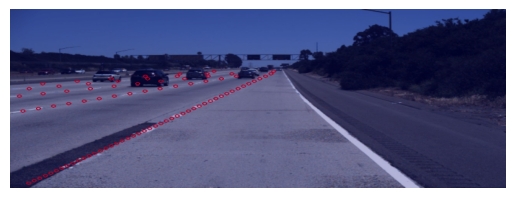

0.835


In [48]:
predict_image(net, acc_enet_sad[-1])

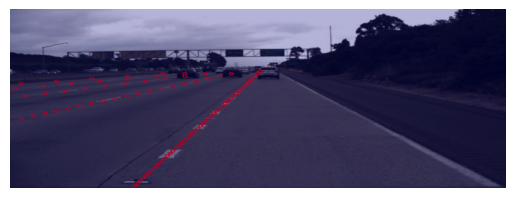

0.826


In [49]:
predict_image(net, acc_enet_sad[-2])

In [50]:
acc_enet_sad[:3]

[(0.17857142857142858, 'clips/0531/1492626549851148880/20.jpg'),
 (0.18452380952380953, 'clips/0531/1492637704295122238/20.jpg'),
 (0.18452380952380953, 'clips/0531/1492637705527704932/20.jpg')]

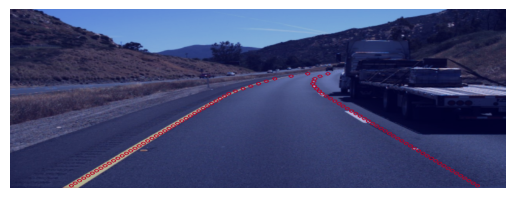

0.179


In [51]:
predict_image(net, acc_enet_sad[0])

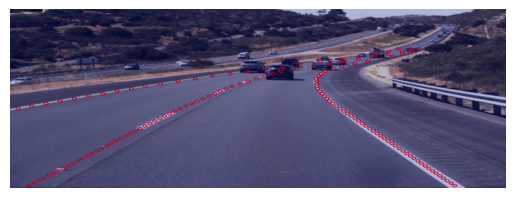

0.185


In [52]:
predict_image(net, acc_enet_sad[1])

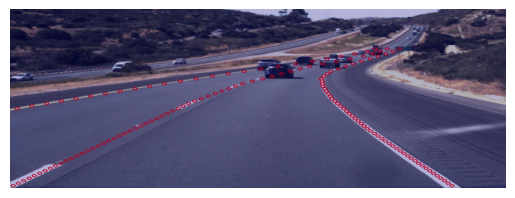

0.185


In [53]:
predict_image(net, acc_enet_sad[2])

## SCNN

In [ ]:
save_dict = torch.load("/kaggle/input/scnn-res/scnn.pth", map_location='cpu')

net = net = SCNN((800, 288), pretrained=False)
net.load_state_dict(save_dict['net'])

In [ ]:
acc_scnn[:3]

In [ ]:
predict_image(net, acc_scnn[-1])

In [ ]:
predict_image(net, acc_scnn[-2])

In [ ]:
predict_image(net, acc_scnn[-90])

In [ ]:
predict_image(net, acc_scnn[0])

In [ ]:
predict_image(net, acc_scnn[1])

In [ ]:
predict_image(net, acc_scnn[2])

# Comparison

## SCNN

In [ ]:
save_dict = torch.load("/kaggle/input/scnn-res/scnn.pth", map_location='cpu')

net = net = SCNN((800, 288), pretrained=False)
net.load_state_dict(save_dict['net'])

In [ ]:
predict_image(net, [x for x in acc_scnn if x[1] == acc_enet[0][1]][0])

In [ ]:
predict_image(net, [x for x in acc_scnn if x[1] == acc_enet[1][1]][0])

In [ ]:
predict_image(net, [x for x in acc_scnn if x[1] == acc_enet[-2][1]][0])

In [ ]:
predict_image(net, [x for x in acc_scnn if x[1] == acc_enet_sad[-1][1]][0])

## ENET-SAD

In [54]:
save_dict = torch.load("G:/lanelanet/models/enet_sad.pth", map_location='cpu')

net = ENet_SAD((800, 288), sad=False, dataset='TUSImple')
net.load_state_dict(save_dict['net'])

<All keys matched successfully>

In [55]:
predict_image(net, [x for x in acc_enet_sad if x[1] == acc_scnn[0][1]][0])

NameError: name 'acc_scnn' is not defined

In [ ]:
predict_image(net, [x for x in acc_enet_sad if x[1] == acc_enet_sad[-1][1]][0])

In [ ]:
predict_image(net, [x for x in acc_enet_sad if x[1] == acc_scnn[-90][1]][0])

## ENET

In [ ]:
save_dict = torch.load("/kaggle/input/enet-res/enet.pth", map_location='cpu')

net = ENet_SAD((800, 288), sad=False, dataset='TUSImple')
net.load_state_dict(save_dict['net'])

In [ ]:
predict_image(net, [x for x in acc_enet if x[1] == acc_enet_sad[-1][1]][0])

In [ ]:
predict_image(net, [x for x in acc_enet if x[1] == acc_scnn[-90][1]][0])

In [ ]:
predict_image(net, acc_scnn[1])

In [ ]:
predict_image(net, acc_scnn[-1])

In [ ]:
predict_image(net, acc_scnn[-2])

In [ ]:

import time
import numpy as np

# Measure latency for training one epoch
start_time = time.time()
epochmain('enet_sad')  # Replace this line with the actual function call
end_time = time.time()

# Calculate latency
latency = end_time - start_time
print(f"Latency: {latency} seconds")

# Assuming `data` is already defined or loaded previously
throughput = len(data) / latency
print(f"Throughput: {throughput} samples/second")


In [ ]:

from joblib import Parallel, delayed

# Function to process data in parallel
def process_data_in_parallel(data_chunk):
    model.train(data_chunk)

# Measure single-core time
start_time = time.time()
for chunk in data:
    model.train(chunk)
single_core_time = time.time() - start_time

# Measure multi-core time
start_time = time.time()
Parallel(n_jobs=-1)(delayed(process_data_in_parallel)(chunk) for chunk in data)
multi_core_time = time.time() - start_time

speedup = single_core_time / multi_core_time
print(f"Speedup: {speedup}")


In [ ]:

import os
import subprocess

# Power consumption measurement
if os.name == 'posix':  # For Linux
    os.system('powerstat -d 1 1')  # Adjust the command and duration as needed
elif os.name == 'nt':  # For Windows
    subprocess.run(["IntelPowerGadget.exe", "-start"], check=True)
    # Run your ML code here
    subprocess.run(["IntelPowerGadget.exe", "-stop"], check=True)
else:
    print("Power consumption measurement is not supported on this OS.")


In [ ]:

import psutil
import time

# Monitor CPU utilization during training
start_time = time.time()
model.train(data)
end_time = time.time()

# Print CPU utilization
cpu_usage = psutil.cpu_percent(interval=1, percpu=True)
print(f"CPU Core Utilization: {cpu_usage}")


In [ ]:

import threading

# Example function to run in a thread
def train_model_in_thread(data_chunk):
    model.train(data_chunk)

# Create threads for parallel processing
threads = []
for chunk in data:
    thread = threading.Thread(target=train_model_in_thread, args=(chunk,))
    threads.append(thread)
    thread.start()

# Join threads
for thread in threads:
    thread.join()

# Measure CPU utilization again
cpu_usage_after = psutil.cpu_percent(interval=1, percpu=True)
print(f"CPU Core Utilization after multithreading: {cpu_usage_after}")


In [ ]:

import time
import numpy as np
from joblib import Parallel, delayed
import os
import subprocess
import psutil
import threading
from your_model import YourModel

def measure_performance(model, data):
    # Measure latency for training one epoch
    start_time = time.time()
    model.epochmain('enet_sad')  # Replace this line with the actual function call
    end_time = time.time()

    # Calculate latency
    latency = end_time - start_time
    print(f"Latency: {latency} seconds")

    # Assuming `data` is already defined or loaded previously
    throughput = len(data) / latency
    print(f"Throughput: {throughput} samples/second")

    # Function to process data in parallel
    def process_data_in_parallel(data_chunk):
        model.train(data_chunk)

    # Measure single-core time
    start_time = time.time()
    for chunk in data:
        model.train(chunk)
    single_core_time = time.time() - start_time

    # Measure multi-core time
    start_time = time.time()
    Parallel(n_jobs=-1)(delayed(process_data_in_parallel)(chunk) for chunk in data)
    multi_core_time = time.time() - start_time

    speedup = single_core_time / multi_core_time
    print(f"Speedup: {speedup}")

    # Power consumption measurement
    if os.name == 'posix':  # For Linux
        os.system('powerstat -d 1 1')  # Adjust the command and duration as needed
    elif os.name == 'nt':  # For Windows
        subprocess.run(["IntelPowerGadget.exe", "-start"], check=True)
        # Run your ML code here
        subprocess.run(["IntelPowerGadget.exe", "-stop"], check=True)
    else:
        print("Power consumption measurement is not supported on this OS.")

    # Monitor CPU utilization during training
    start_time = time.time()
    model.train(data)
    end_time = time.time()

    # Print CPU utilization
    cpu_usage = psutil.cpu_percent(interval=1, percpu=True)
    print(f"CPU Core Utilization: {cpu_usage}")

    # Example function to run in a thread
    def train_model_in_thread(data_chunk):
        model.train(data_chunk)

    # Create threads for parallel processing
    threads = []
    for chunk in data:
        thread = threading.Thread(target=train_model_in_thread, args=(chunk,))
        threads.append(thread)
        thread.start()

    # Join threads
    for thread in threads:
        thread.join()

    # Measure CPU utilization again
    cpu_usage_after = psutil.cpu_percent(interval=1, percpu=True)
    print(f"CPU Core Utilization after multithreading: {cpu_usage_after}")

# Initialize your model and dataset
model = YourModel()
data = np.load('openlane_dataset.npy')

# Call the performance measurement function
measure_performance(model, data)
